In [13]:
import glob
from pathlib import Path
import pandas as pd
%matplotlib inline
import hvplot.pandas
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [14]:
files_path = glob.glob('./coins/ETH/*.csv')
eth_dfs = []
for file_path in files_path:
    eth = pd.read_csv(file_path, sep=';')
    eth_dfs.append(eth)
eth = pd.concat(eth_dfs, axis='rows', join='inner')
eth['Date'] = pd.DatetimeIndex(eth['timestamp'], freq='D')
eth.set_index('Date', inplace=True)
eth.drop(columns=['timestamp'], inplace=True)
eth


,open,high,low,close,volume,marketCap
Date,,,,,,
2020-01-01 00:00:00+00:00,129.630656,132.835357,129.198285,130.802008,7.935230e+09,1.427106e+10
2020-01-02 00:00:00+00:00,130.820038,130.820038,126.954911,127.410182,8.032709e+09,1.390251e+10
2020-01-03 00:00:00+00:00,127.411261,134.554014,126.490020,134.171712,1.047685e+10,1.464213e+10
2020-01-04 00:00:00+00:00,134.168523,136.052714,133.040551,135.069371,7.430905e+09,1.474195e+10
2020-01-05 00:00:00+00:00,135.072094,139.410202,135.045629,136.276777,7.526675e+09,1.487557e+10
...,...,...,...,...,...,...
2023-05-20 00:00:00+00:00,1812.766060,1829.009603,1808.046731,1820.478001,2.951656e+09,2.189539e+11
2023-05-21 00:00:00+00:00,1820.138100,1827.922002,1799.946875,1804.531380,3.386769e+09,2.170329e+11
2023-05-22 00:00:00+00:00,1804.841868,1826.696581,1793.224036,1817.534825,4.534841e+09,2.185938e+11


In [15]:
eth.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1240 entries, 2020-01-01 00:00:00+00:00 to 2023-05-24 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1240 non-null   float64
 1   high       1240 non-null   float64
 2   low        1240 non-null   float64
 3   close      1240 non-null   float64
 4   volume     1240 non-null   float64
 5   marketCap  1240 non-null   float64
dtypes: float64(6)
memory usage: 67.8 KB


## First: Decompose Time Series Components to Trend, Seasonality, & Noise

<Axes: title={'center': 'Ether'}, xlabel='Date'>

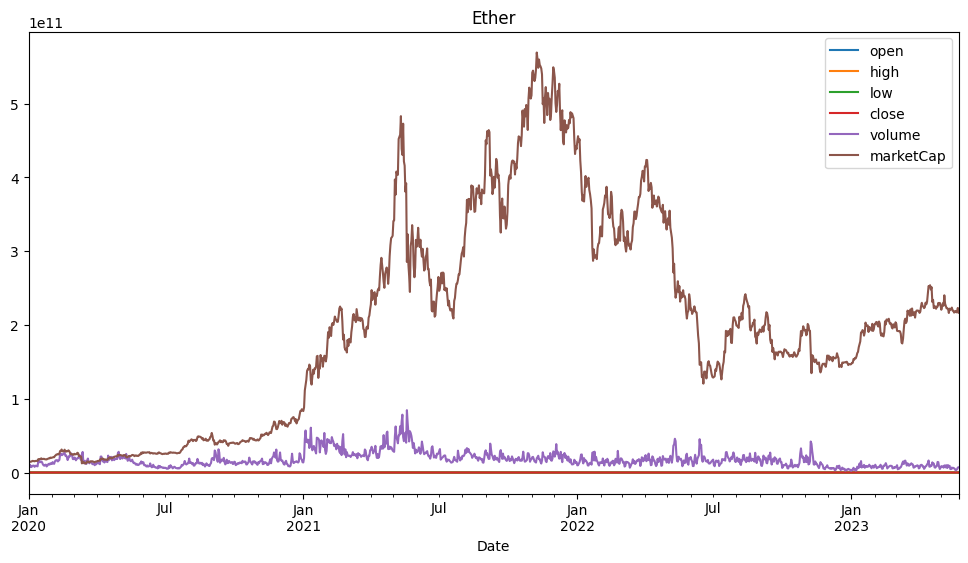

In [16]:
eth.plot(title='Ether',figsize=(12,6))

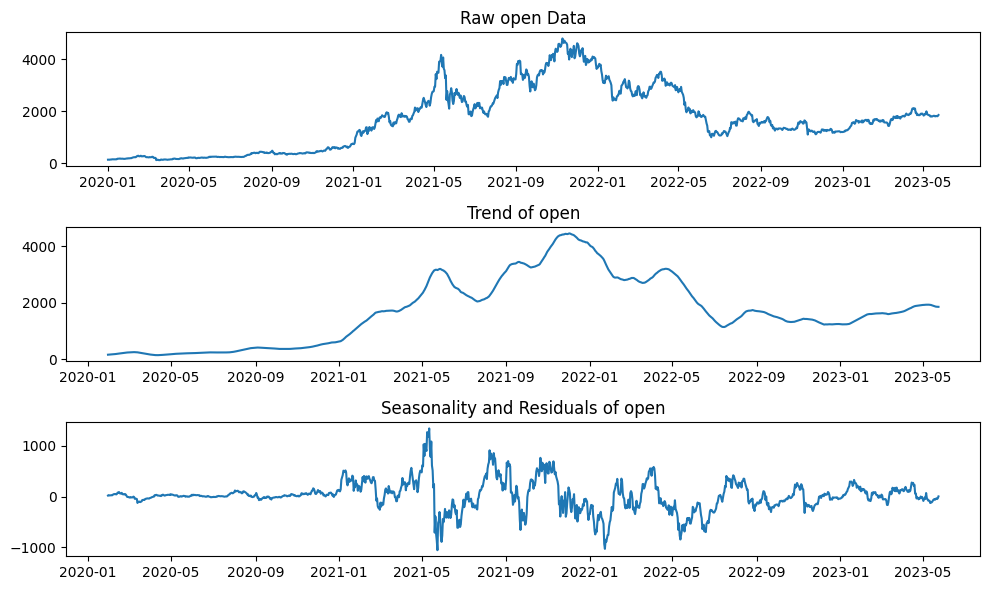

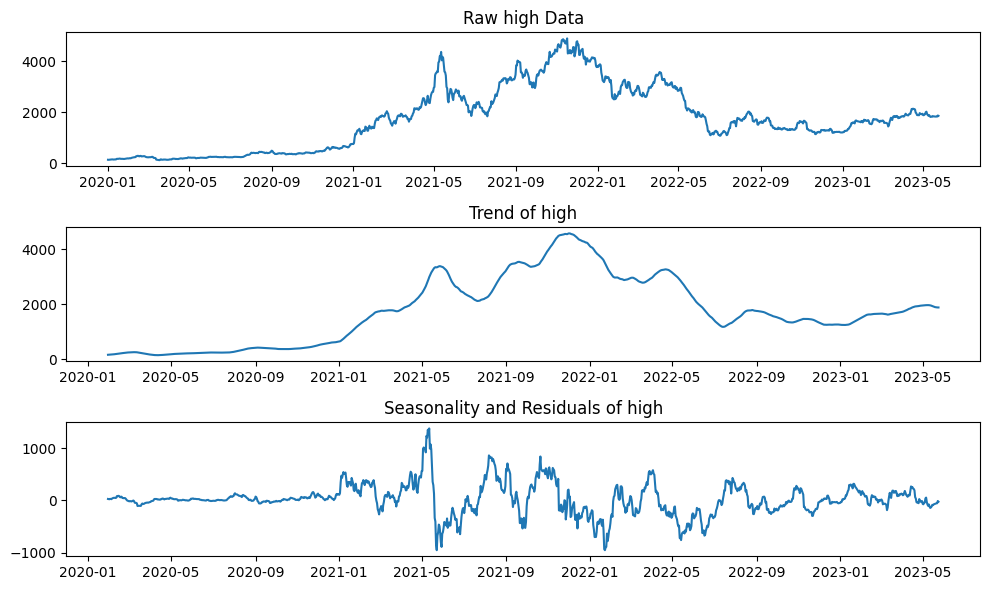

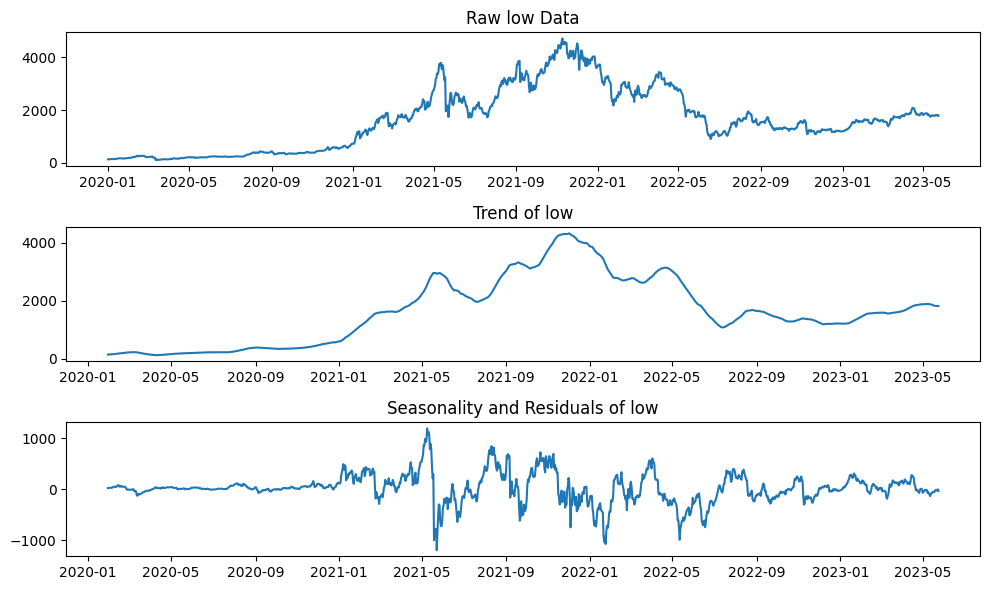

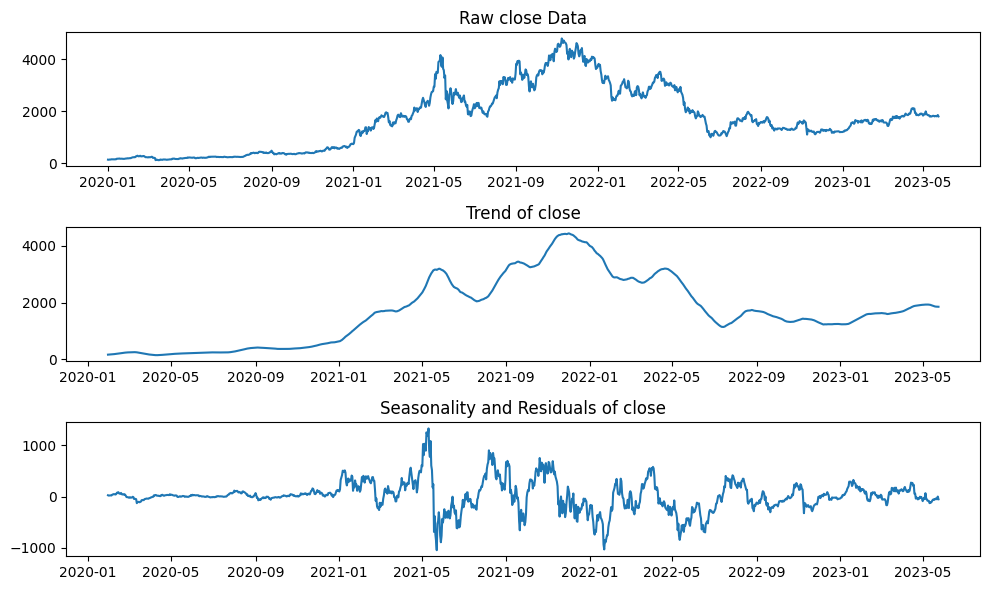

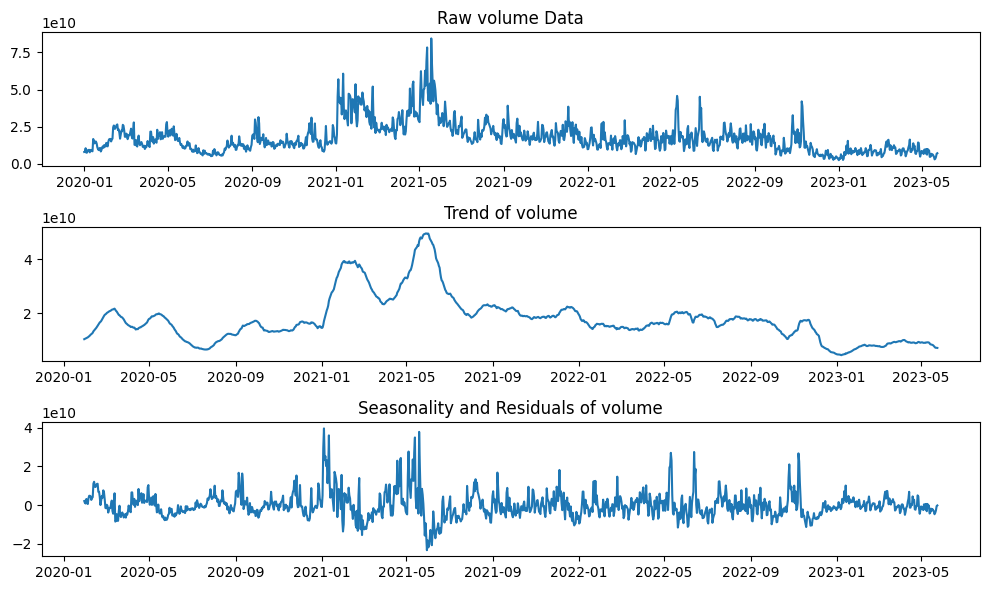

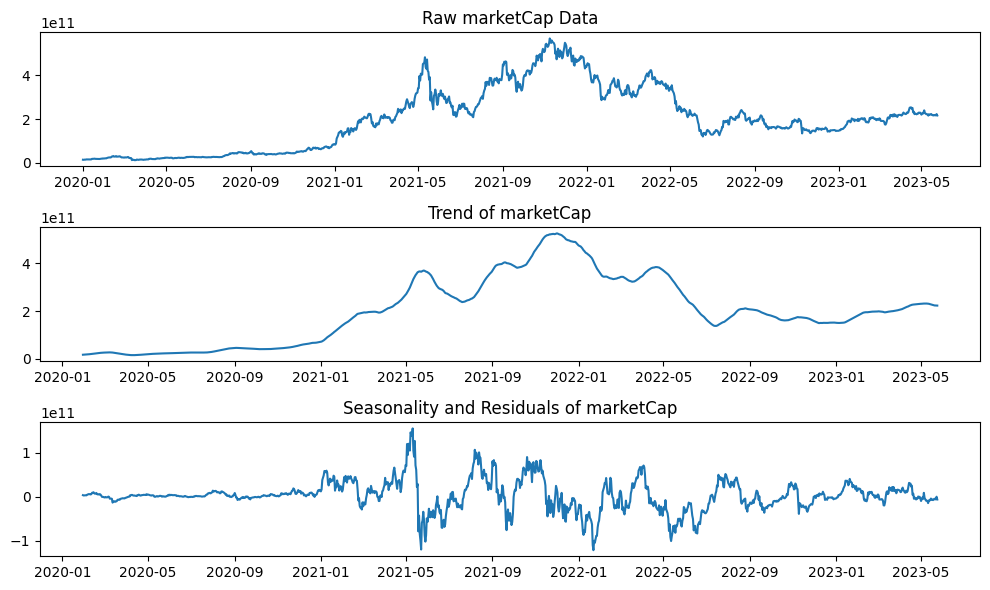

In [17]:
import matplotlib.pyplot as plt
# Define the parameters to decompose
parameters = ['open', 'high', 'low', 'close', 'volume', 'marketCap']

# Perform time series decomposition for each parameter
for parameter in parameters:
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(eth[parameter])
    plt.title(f"Raw {parameter} Data")
    
    plt.subplot(3, 1, 2)
    plt.plot(eth[parameter].rolling(window=30).mean())
    plt.title(f"Trend of {parameter}")
    
    plt.subplot(3, 1, 3)
    plt.plot(eth[parameter] - eth[parameter].rolling(window=30).mean())
    plt.title(f"Seasonality and Residuals of {parameter}")
    
    plt.tight_layout()
    plt.show()

### Second: Check Autocorrelation & Partial Autocorrelation of different Prices

2-1: Open Prices ACF & PACF

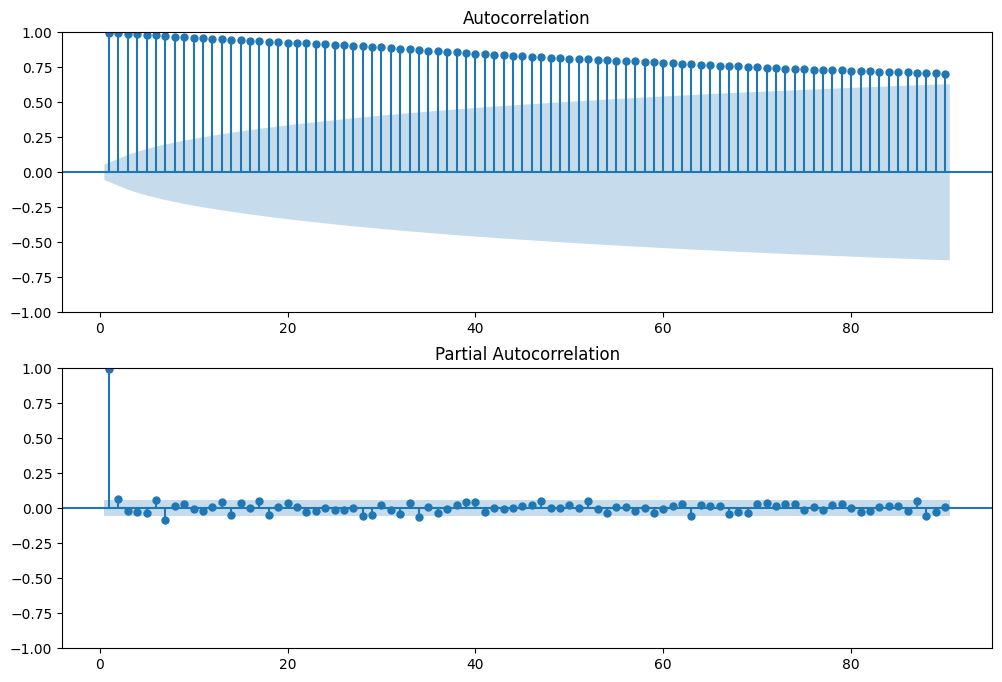

In [18]:
# Plot ACF / PCAF of `open` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.open.squeeze(), lags=90, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.open.squeeze(), lags=90, ax=ax2, zero=False)

2-2: Close Prices ACF & PACF

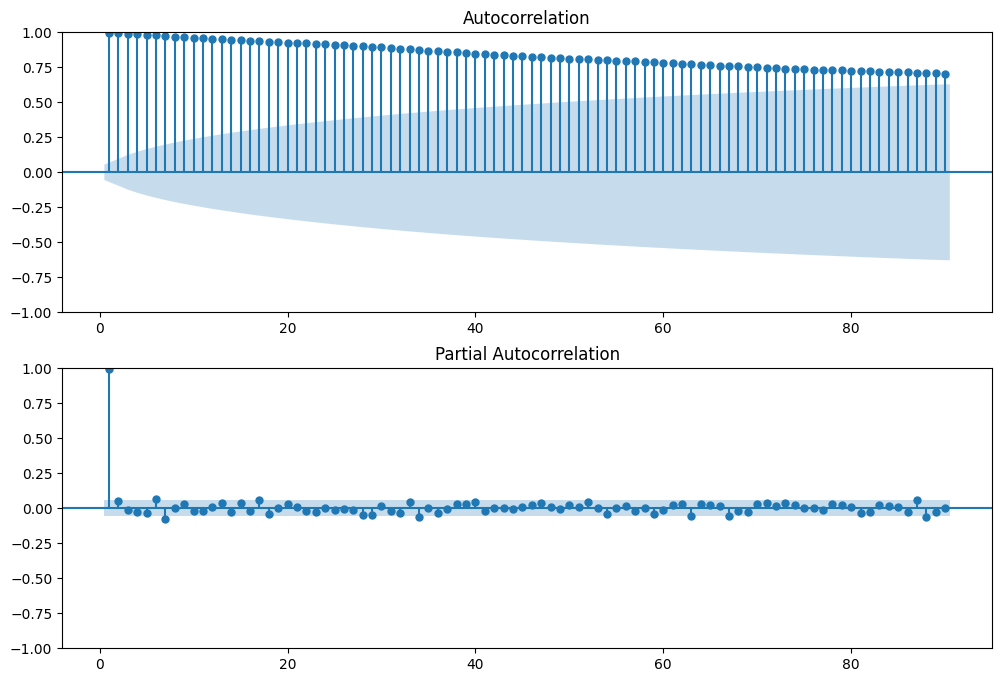

In [19]:
# Plot ACF / PCAF of `close` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.close.squeeze(), lags=90, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.close.squeeze(), lags=90, ax=ax2, zero=False)

2-3: High Prices Autocorrelation

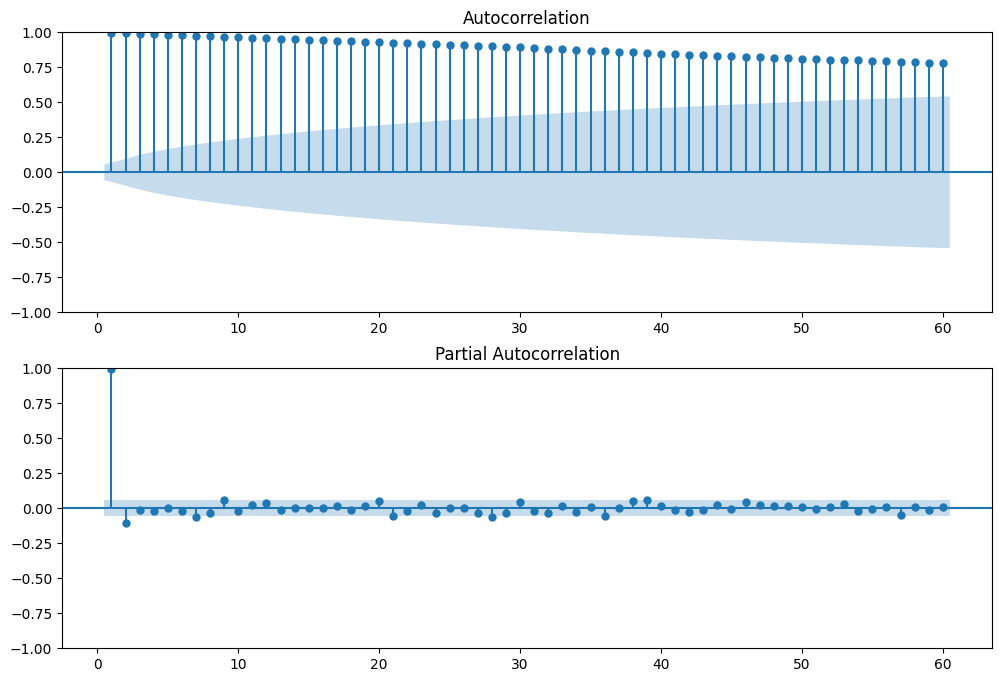

In [20]:
# Plot ACF / PCAF of `high` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.high.squeeze(), lags=60, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.high.squeeze(), lags=60, ax=ax2, zero=False)

2-4: Low Prices Autocorrelation

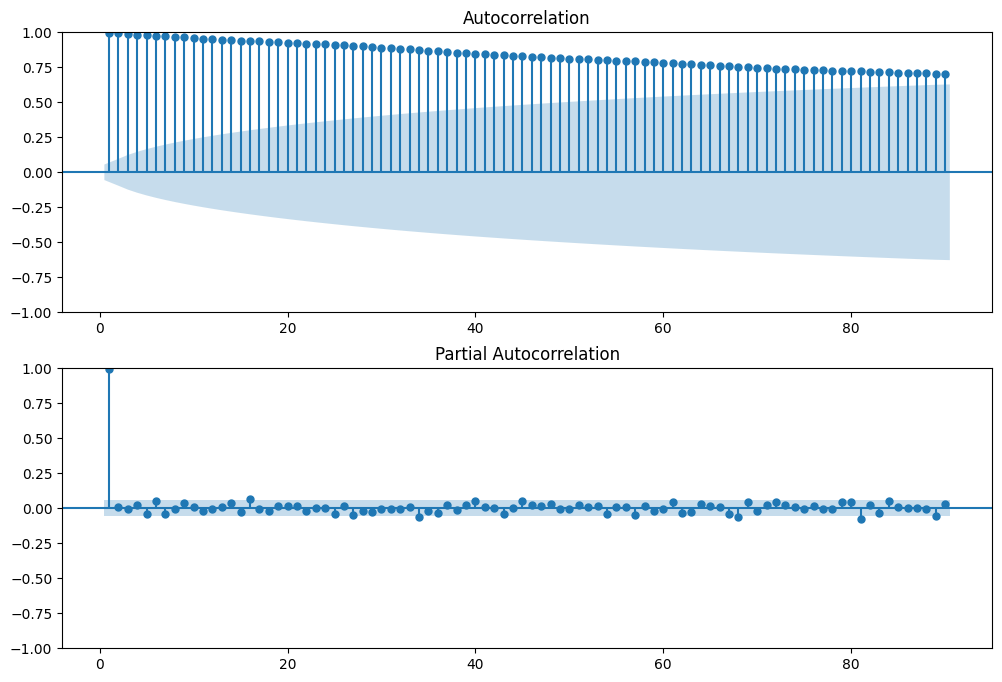

In [21]:
# Plot ACF/PCAF of `low` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.low.squeeze(), lags=90, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.low.squeeze(), lags=90, ax=ax2, zero=False)

    Observation:
        it appears that there is strong autocorrelation in the ACF up to lag 10, suggesting a non-seasonal AR component. 
        The lack of significant correlation in the PACF beyond the first lag indicates that an MA component may not be necessary.

### Third: Check if Data is Stationary using Augmented Dickey-Fuller 

In [22]:
# Apply Augmented Dickey-Fuller test to check stationary
adfuller(eth.close)

(-1.7393044606153438,
 0.41098381231839054,
 6,
 1233,
 {'1%': -3.4356646522289815,
  '5%': -2.863886926389418,
  '10%': -2.568019536239491},
 14564.163628486443)

    Observation:
        with p-value of 0.4 it indicates that data are non-stationary

In [23]:
adfuller(eth.open)

(-1.7499174452031652,
 0.40559417337756465,
 6,
 1233,
 {'1%': -3.4356646522289815,
  '5%': -2.863886926389418,
  '10%': -2.568019536239491},
 14582.443995650856)

    Observation:
        with p-value of 0.7 it indicates that data are non-stationary

In [24]:
adfuller(eth.high)

(-1.7111237820700707,
 0.4253904752400304,
 8,
 1231,
 {'1%': -3.435673305025808,
  '5%': -2.863890744031555,
  '10%': -2.56802156936202},
 14069.267053665446)

    Observation:
        with p-value of 0.4 it indicates that data are non-stationar

In [25]:
adfuller(eth.low)

(-1.765374153679963,
 0.3977828480048589,
 0,
 1239,
 {'1%': -3.435638861796935,
  '5%': -2.863875547501718,
  '10%': -2.5680134763122906},
 14611.664331708758)

    Observation:
        with p-value of 0.4 it indicates that data are non-stationary

### Fourth: Convert Non Stationary Data to Stationary 

<Axes: title={'center': 'CLOSE PRICES'}, xlabel='Date'>

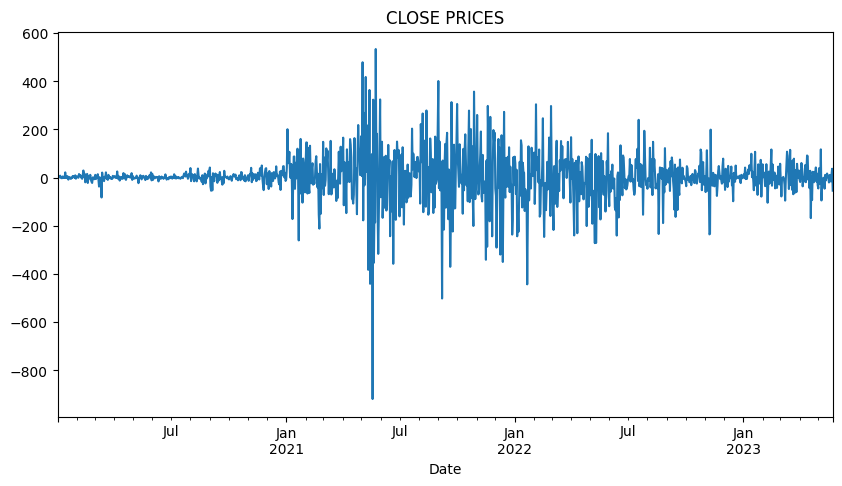

In [26]:
# convert to stationary using diff() function to subtract the trend
close_stationary = eth.close.diff().dropna()
close_stationary.plot(title='CLOSE PRICES',figsize=(10, 5))


<Axes: title={'center': 'OPEN PRICES'}, xlabel='Date'>

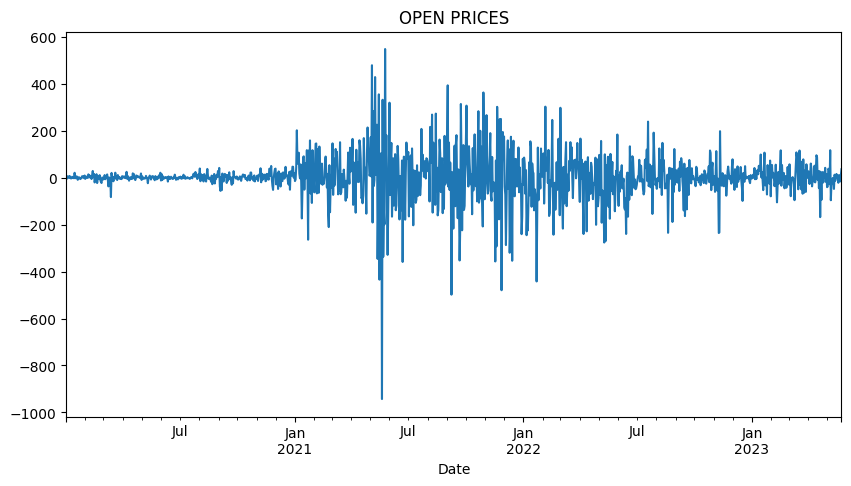

In [27]:
# convert to stationary using diff() function to subtract the trend
open_stationary = eth.open.diff().dropna()
open_stationary.plot(title='OPEN PRICES',figsize=(10, 5))

<Axes: title={'center': 'HIGH PRICES'}, xlabel='Date'>

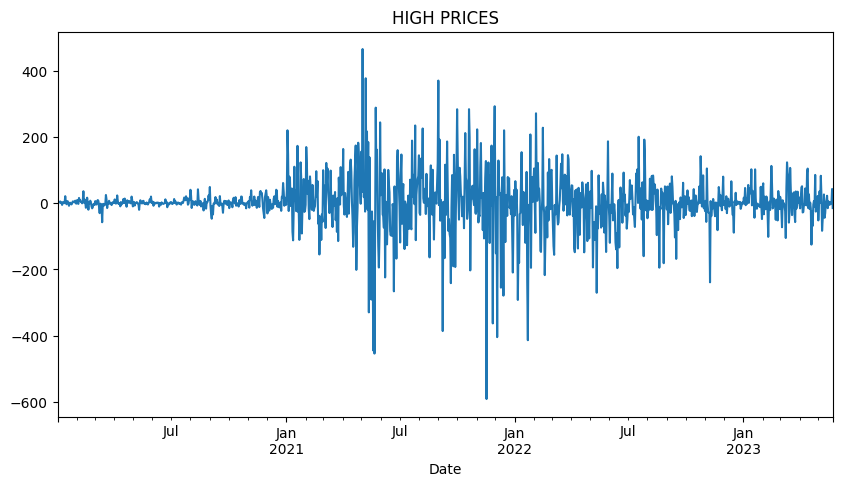

In [28]:
# convert to stationary using diff() function to subtract the trend
high_stationary = eth.high.diff().dropna()
high_stationary.plot(title='HIGH PRICES',figsize=(10, 5))

    Conclusion:
        Given the presence of autocorrelation between past values and errors, and considering that the data 
        has been transformed to stationary form, the ARMA model is well-suited for predicting future prices

In [29]:
model = arch_model(diff_returns, mean='zero', vol='GARCH', p=1, q=1)
volatility = model.fit(disp='off')
volatility.summary()

NameError: name 'diff_returns' is not defined

In [96]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [124]:
# save a copy from dataframe & drop unused columns in model
df = eth.copy()
df.drop(columns=['open', 'volume', 'marketCap'], inplace=True)
df

,high,low,close
Date,,,
2020-01-01 00:00:00+00:00,132.835357,129.198285,130.802008
2020-01-02 00:00:00+00:00,130.820038,126.954911,127.410182
2020-01-03 00:00:00+00:00,134.554014,126.490020,134.171712
2020-01-04 00:00:00+00:00,136.052714,133.040551,135.069371
2020-01-05 00:00:00+00:00,139.410202,135.045629,136.276777
...,...,...,...
2023-05-20 00:00:00+00:00,1829.009603,1808.046731,1820.478001
2023-05-21 00:00:00+00:00,1827.922002,1799.946875,1804.531380
2023-05-22 00:00:00+00:00,1826.696581,1793.224036,1817.534825


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1240 entries, 2020-01-01 00:00:00+00:00 to 2023-05-24 00:00:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    1240 non-null   float64
 1   low     1240 non-null   float64
 2   close   1240 non-null   float64
dtypes: float64(3)
memory usage: 38.8 KB


In [99]:
def window_data(df, window, feature_col_numbers, target_col_numbers):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_numbers]
        targets = df.iloc[(i + window), target_col_numbers]
        X.append(features)
        y.append(targets)
    return np.array(X), np.array(y)

In [100]:
window_size = 24
# open, high, low, close columns
feature_columns = [0, 1, 2]
target_columns = [0, 1, 2]
X, y = window_data(df, window_size, feature_columns, target_columns)

In [101]:
# splitting data bet 70%  train and 30% test of each column
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

850
850
365
365


In [104]:
# scale data before training the model with MinMaxScaler to scale values between 0 & 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the training data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, len(feature_columns)))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, len(target_columns)))

# Scale the test data
X_test_scaled = scaler.transform(X_test.reshape(-1, len(feature_columns)))
y_test_scaled = scaler.transform(y_test.reshape(-1, len(target_columns)))

In [105]:
# Reshape the training data
# X_train_reshaped: (sample, time steps, features)=(850, 24, 3)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], window_size, len(feature_columns)))
# y_train_reshaped:(850,3)
y_train_reshaped = y_train_scaled.reshape((y_train.shape[0], len(target_columns)))

# Reshape the test data
# X_test_reshaped: (sample, time steps, features)=(850, 24, 3)
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], window_size, len(feature_columns)))
# y_test_reshaped:(850,3)
y_test_reshaped = y_test_scaled.reshape((y_test.shape[0], len(target_columns)))

In [106]:
# Define the LSTM RNN model
model = Sequential()
#Input layer
model.add(LSTM(units=24, return_sequences=True, input_shape=(window_size, len(feature_columns))))
model.add(Dropout(0.2))
# layer 2
model.add(LSTM(units=24, return_sequences=True))
model.add(Dropout(0.2))
# layer 3
model.add(LSTM(units=24, return_sequences=True))
model.add(Dropout(0.2))
# layer 4
model.add(LSTM(units=24))
model.add(Dropout(0.2))
# Output layer
model.add(Dense(len(target_columns)))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train_reshaped, epochs=100, batch_size=32, verbose=2)

# Make predictions on the training set
predicted_train = model.predict(X_train_reshaped)
mse_train = mean_squared_error(y_train_reshaped, predicted_train)
print("MSE for train set:", mse_train)

# Make predictions on the test set
predicted_test = model.predict(X_test_reshaped)
mse_test = mean_squared_error(y_test_reshaped, predicted_test)
print("MSE for test set:", mse_test)

Epoch 1/100
27/27 - 7s - loss: 0.0672 - 7s/epoch - 269ms/step
Epoch 2/100
27/27 - 1s - loss: 0.0166 - 738ms/epoch - 27ms/step
Epoch 3/100
27/27 - 1s - loss: 0.0147 - 597ms/epoch - 22ms/step
Epoch 4/100
27/27 - 1s - loss: 0.0138 - 626ms/epoch - 23ms/step
Epoch 5/100
27/27 - 1s - loss: 0.0118 - 681ms/epoch - 25ms/step
Epoch 6/100
27/27 - 1s - loss: 0.0126 - 633ms/epoch - 23ms/step
Epoch 7/100
27/27 - 1s - loss: 0.0132 - 610ms/epoch - 23ms/step
Epoch 8/100
27/27 - 1s - loss: 0.0100 - 713ms/epoch - 26ms/step
Epoch 9/100
27/27 - 1s - loss: 0.0098 - 695ms/epoch - 26ms/step
Epoch 10/100
27/27 - 1s - loss: 0.0109 - 596ms/epoch - 22ms/step
Epoch 11/100
27/27 - 1s - loss: 0.0101 - 597ms/epoch - 22ms/step
Epoch 12/100
27/27 - 1s - loss: 0.0087 - 597ms/epoch - 22ms/step
Epoch 13/100
27/27 - 1s - loss: 0.0090 - 680ms/epoch - 25ms/step
Epoch 14/100
27/27 - 1s - loss: 0.0078 - 615ms/epoch - 23ms/step
Epoch 15/100
27/27 - 1s - loss: 0.0078 - 595ms/epoch - 22ms/step
Epoch 16/100
27/27 - 1s - loss: 0.00

In [107]:
# Summarize the model
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 24, 24)            2688      
                                                                 
 dropout_77 (Dropout)        (None, 24, 24)            0         
                                                                 
 lstm_78 (LSTM)              (None, 24, 24)            4704      
                                                                 
 dropout_78 (Dropout)        (None, 24, 24)            0         
                                                                 
 lstm_79 (LSTM)              (None, 24, 24)            4704      
                                                                 
 dropout_79 (Dropout)        (None, 24, 24)            0         
                                                                 
 lstm_80 (LSTM)              (None, 24)              

In [108]:
# Evaluate the model
loss = model.evaluate(X_test_reshaped, y_test_reshaped)
loss

12/12 [==============================] - 2s 7ms/step - loss: 4.7982e-04


0.0004798182053491473

In [118]:
# Inverse scaling to obtain the original prices
predicted_train_inv = scaler.inverse_transform(predicted_train)
predicted_test_inv = scaler.inverse_transform(predicted_test)
predicted_test_inv

array([[2025.7343, 1903.3623, 1981.2208],
       [2026.1129, 1903.5813, 1981.7886],
       [2026.5735, 1903.5782, 1982.4908],
       ...,
       [1873.4281, 1754.2509, 1834.0322],
       [1872.7039, 1753.3535, 1833.41  ],
       [1871.0553, 1751.6342, 1831.9036]], dtype=float32)

In [132]:
# Inverse scaling to obtain the original prices
y_test_inv = scaler.inverse_transform(y_test_reshaped)

# Create a new DataFrame using the predicted and real values
predicted_df = pd.DataFrame({
    "Predicted High": predicted_test_inv[:, 0],
    "Real High": df["high"][-len(y_test_inv):].values,
    "Predicted Low": predicted_test_inv[:, 1],
    "Real Low": df["low"][-len(y_test_inv):].values,
    "Predicted Close": predicted_test_inv[:, 2],
    "Real Close": df["close"][-len(y_test_inv):].values
}, index=df.index[-len(y_test_inv):])

predicted_df.tail()


,Predicted High,Real High,Predicted Low,Real Low,Predicted Close,Real Close
Date,,,,,,
2023-05-20 00:00:00+00:00,1868.098755,1829.009603,1749.574463,1808.046731,1828.902344,1820.478001
2023-05-21 00:00:00+00:00,1872.108032,1827.922002,1753.203857,1799.946875,1832.716553,1804.531380
2023-05-22 00:00:00+00:00,1873.428101,1826.696581,1754.250854,1793.224036,1834.032227,1817.534825
2023-05-23 00:00:00+00:00,1872.703857,1869.344019,1753.353516,1816.287938,1833.410034,1854.380631
2023-05-24 00:00:00+00:00,1871.055298,1854.299709,1751.634155,1780.925500,1831.903564,1800.100017


In [133]:
predicted_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-05-25 00:00:00+00:00 to 2023-05-24 00:00:00+00:00
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Predicted High   365 non-null    float32
 1   Real High        365 non-null    float64
 2   Predicted Low    365 non-null    float32
 3   Real Low         365 non-null    float64
 4   Predicted Close  365 non-null    float32
 5   Real Close       365 non-null    float64
dtypes: float32(3), float64(3)
memory usage: 15.7 KB


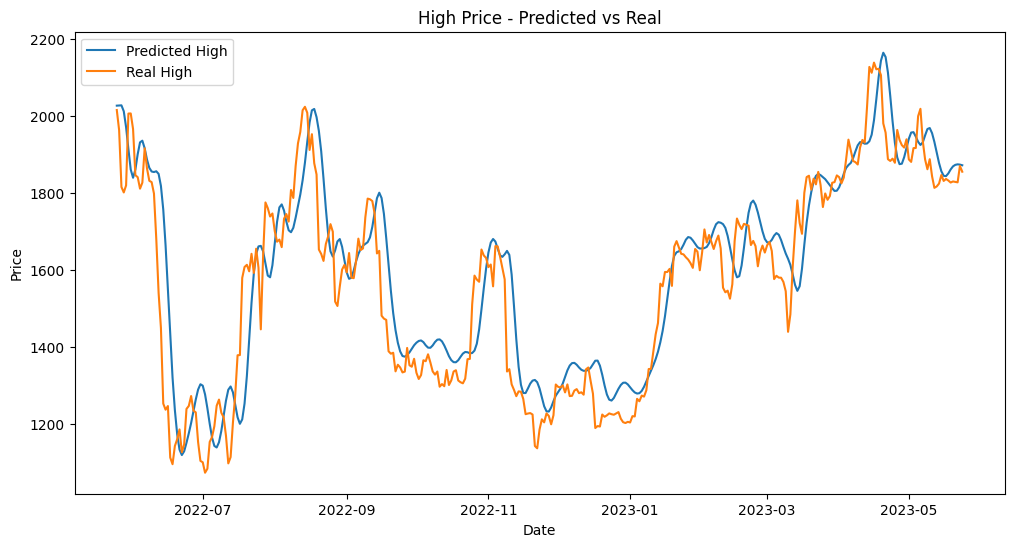

In [134]:
# Plotting the predicted and real values for High
plt.figure(figsize=(12, 6))
plt.plot(predicted_df.index, predicted_df["Predicted High"], label="Predicted High")
plt.plot(predicted_df.index, predicted_df["Real High"], label="Real High")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("High Price - Predicted vs Real")
plt.legend()
plt.show()

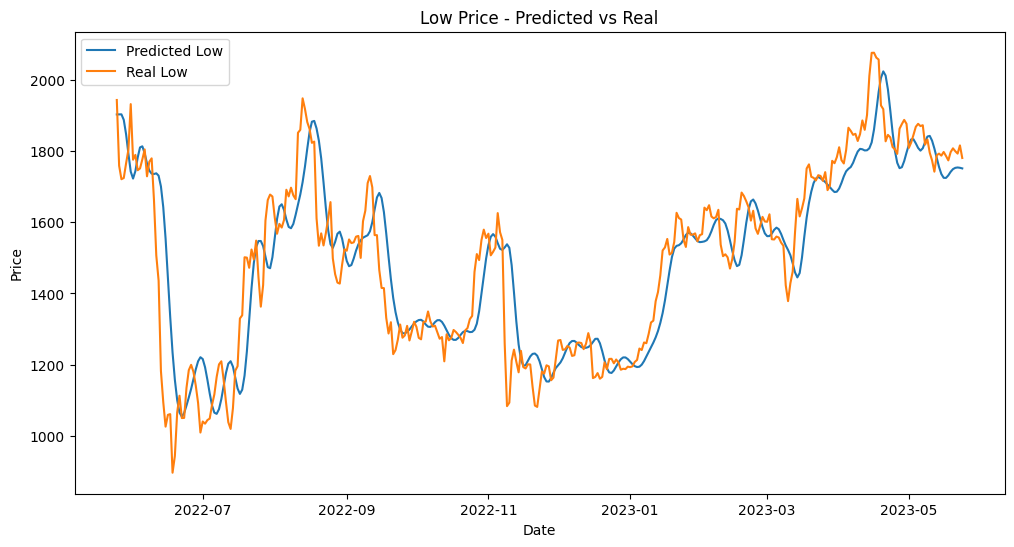

In [135]:
# Plotting the predicted and real values for Low
plt.figure(figsize=(12, 6))
plt.plot(predicted_df.index, predicted_df["Predicted Low"], label="Predicted Low")
plt.plot(predicted_df.index, predicted_df["Real Low"], label="Real Low")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Low Price - Predicted vs Real")
plt.legend()
plt.show()

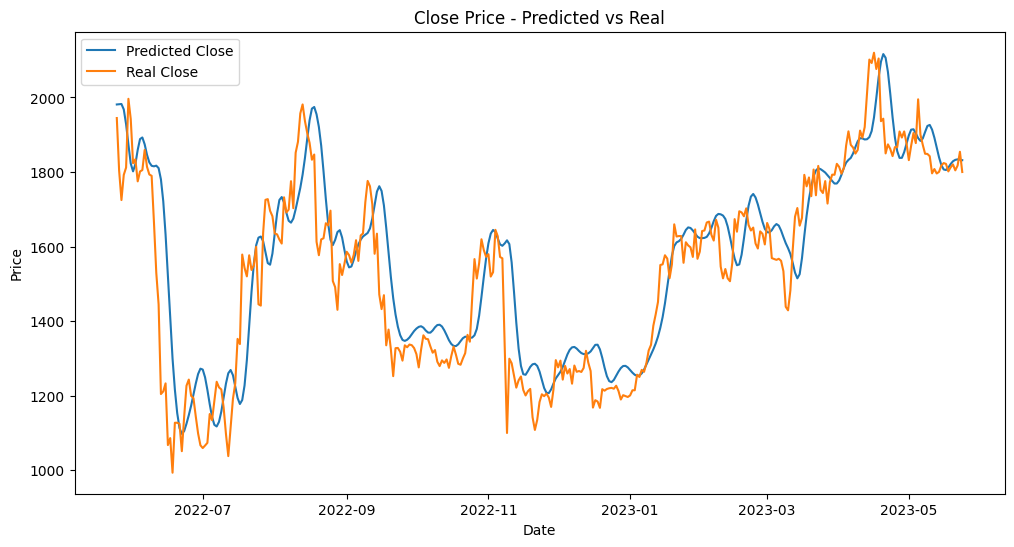

In [136]:
# Plotting the predicted and real values for Close
plt.figure(figsize=(12, 6))
plt.plot(predicted_df.index, predicted_df["Predicted Close"], label="Predicted Close")
plt.plot(predicted_df.index, predicted_df["Real Close"], label="Real Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price - Predicted vs Real")
plt.legend()
plt.show()

# predict prices till end of 2023

In [157]:
# Define the number of future time steps to predict
num_steps = 200
num_features = 3  # Number of features (high, low, close)

# Create a copy of the original DataFrame to store the predicted prices
predicted_prices_df = pd.DataFrame(index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=num_steps))

# Iterate for the desired number of time steps
for _ in range(num_steps):
    # Prepare the input data for prediction
    input_data = df[-window_size:].values
    input_data_scaled = scaler.transform(input_data)
    input_data_reshaped = input_data_scaled.reshape((1, window_size, num_features))

    # Make the prediction
    predicted_values_scaled = model.predict(input_data_reshaped)
    predicted_values = scaler.inverse_transform(predicted_values_scaled)

    # Create a DataFrame to store the predicted values for the current time step
    predicted_step_df = pd.DataFrame(
        predicted_values.reshape(1, -1),
        columns=["Predicted High", "Predicted Low", "Predicted Close"],
        index=[predicted_prices_df.index[-1]]
    )

    # Append the predicted values to the main DataFrame
    predicted_prices_df = pd.concat([predicted_prices_df, predicted_step_df])
predicted_prices_df

1/1 [==============================] - 0s 104ms/step


,Predicted High,Predicted Low,Predicted Close
2023-05-25 00:00:00+00:00,NaN,NaN,NaN
2023-05-26 00:00:00+00:00,NaN,NaN,NaN
2023-05-27 00:00:00+00:00,NaN,NaN,NaN
2023-05-28 00:00:00+00:00,NaN,NaN,NaN
2023-05-29 00:00:00+00:00,NaN,NaN,NaN
...,...,...,...
2023-12-10 00:00:00+00:00,1875.897583,1756.13501,1836.733032
2023-12-10 00:00:00+00:00,1875.897583,1756.13501,1836.733032
2023-12-10 00:00:00+00:00,1875.897583,1756.13501,1836.733032
2023-12-10 00:00:00+00:00,1875.897583,1756.13501,1836.733032


In [176]:
# Define the number of future time steps to predict
num_steps = 200
num_features = 3  # Number of features (high, low, close)

# Create an empty DataFrame to store the predicted prices
predicted_prices_df = pd.DataFrame(columns=["Predicted High", "Predicted Low", "Predicted Close"])

# Get the last date from the original DataFrame
last_date = df.index[-1]

# Iterate for the desired number of time steps
for _ in range(num_steps):
    # Prepare the input data for prediction
    input_data = df[-window_size:].values
    input_data_scaled = scaler.transform(input_data)
    input_data_reshaped = input_data_scaled.reshape((1, window_size, num_features))

    # Make the prediction
    predicted_values_scaled = model.predict(input_data_reshaped)
    predicted_values = scaler.inverse_transform(predicted_values_scaled)

    # Create a DataFrame to store the predicted values for the current time step
    predicted_step_df = pd.DataFrame(
        predicted_values.reshape(1, -1),
        columns=["Predicted High", "Predicted Low", "Predicted Close"]
    )

    # Get the next date by adding one day to the last date
    next_date = last_date + pd.DateOffset(days=1)

    # Set the index of the predicted step DataFrame to the next date
    predicted_step_df.index = [next_date.strftime('%d-%m-%Y')]

    # Concatenate the predicted step DataFrame with the main DataFrame
    predicted_prices_df = pd.concat([predicted_prices_df, predicted_step_df])

    # Update the last date
    last_date = next_date

predicted_prices_df

1/1 [==============================] - 0s 102ms/step


,Predicted High,Predicted Low,Predicted Close
25-05-2023,1875.897583,1756.13501,1836.733032
26-05-2023,1875.897583,1756.13501,1836.733032
27-05-2023,1875.897583,1756.13501,1836.733032
28-05-2023,1875.897583,1756.13501,1836.733032
29-05-2023,1875.897583,1756.13501,1836.733032
...,...,...,...
06-12-2023,1875.897583,1756.13501,1836.733032
07-12-2023,1875.897583,1756.13501,1836.733032
08-12-2023,1875.897583,1756.13501,1836.733032
09-12-2023,1875.897583,1756.13501,1836.733032


In [178]:
# Reset the index and assign a name to the index column
predicted_prices_df.reset_index(inplace=True)
predicted_prices_df.rename(columns={'index': 'Date'}, inplace=True)
predicted_prices_df.set_index('Date', inplace=True)

# Display the DataFrame
predicted_prices_df


,Predicted High,Predicted Low,Predicted Close
Date,,,
25-05-2023,1875.897583,1756.13501,1836.733032
26-05-2023,1875.897583,1756.13501,1836.733032
27-05-2023,1875.897583,1756.13501,1836.733032
28-05-2023,1875.897583,1756.13501,1836.733032
29-05-2023,1875.897583,1756.13501,1836.733032
...,...,...,...
06-12-2023,1875.897583,1756.13501,1836.733032
07-12-2023,1875.897583,1756.13501,1836.733032
08-12-2023,1875.897583,1756.13501,1836.733032


In [179]:
predicted_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 25-05-2023 to 10-12-2023
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Predicted High   200 non-null    float32
 1   Predicted Low    200 non-null    float32
 2   Predicted Close  200 non-null    float32
dtypes: float32(3)
memory usage: 3.9+ KB


In [180]:
predicted_prices_df.isnull().sum()

Predicted High     0
Predicted Low      0
Predicted Close    0
dtype: int64

In [181]:
# Save predicted prices DataFrame to JSON
predicted_prices_df.to_json('./coins/ETH/predicted_prices.json')

# Save predicted prices DataFrame to CSV
predicted_prices_df.to_csv('./coins/ETH/predicted_prices.csv')